# 📊 Explorative Datenanalyse (EDA)
## FDI-Rating Prediction für professionelle Darts-Spieler

**Modul:** Data Analytics with Statistics | HdM Stuttgart  
**Autor:** Simon  
**Datum:** Januar 2026  

---

### 🎯 Forschungsfrage

> *Lässt sich das **FDI-Rating** (Future Dart Intelligence) eines professionellen Darts-Spielers aus dessen Spielstatistiken vorhersagen?*

### Datenquelle
- **DartsOrakel.com** – umfassendste Darts-Statistik-Plattform weltweit
- **Zielvariable:** `profile_fdi_rating` (kontinuierlich, 50–800)  
- **Prädiktoren:** Performance-Metriken (3-Dart Average, Checkout %, 180er) + Erfolgs-Indikatoren (Preisgeld, Ranking)

### Strategie
Diese explorative Analyse untersucht:
1. **Datenqualität** – Fehlwerte, Ausreißer, Verteilungen
2. **Univariate Muster** – Verteilung der Zielvariable und wichtiger Features
3. **Bivariate Zusammenhänge** – Korrelationen, Scatterplots
4. **Multivariate Strukturen** – Länder-Effekte, Interaktionen

**Ziel:** Ein fundiertes Verständnis schaffen, um anschließend robuste Modelle zu trainieren.

---

## 1. Daten laden & Basis-Überblick

In diesem Abschnitt laden wir den aufbereiteten Datensatz und verschaffen uns einen ersten Überblick über Struktur, Größe und Datentypen.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use("seaborn-v0_8")
sns.set_theme(context="notebook", style="whitegrid", palette="deep")

PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "data").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
DATA_PATH = PROJECT_ROOT / "data/processed/player_stats_all.csv"
if not DATA_PATH.exists():
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}")

df = pd.read_csv(DATA_PATH)
df["log_total_earnings"] = np.log1p(df["profile_total_earnings"].clip(lower=0).fillna(0))
df["country"] = df["country_code"].fillna("UNK")
print(f"Rows: {df.shape[0]:,} | Columns: {df.shape[1]}")
df.head()

Rows: 2,978 | Columns: 34


,player_id,player_name,country_code,birth_date,age,profile_total_earnings,profile_9_darters,profile_season_win_pct,profile_tour_card_years,profile_fdi_rating,...,last_12_months_171_180_s,last_12_months_140_s,last_12_months_131_140_s,last_12_months_functional_doubles_pcnt,api_rank,api_overall_stat,api_sum_field1,api_sum_field2,log_total_earnings,country
0,5403,Luke Littler,ENG,21/01/2007,18.0,2141879.0,8.0,80.0,1.0,1972.0,...,998.0,1268.0,1960.0,49.31,1,100.96,983928,29236,14.577195,ENG
1,34,Luke Humphries,ENG,11/02/1995,30.0,3326675.0,6.0,68.0,7.0,1876.0,...,586.0,1131.0,1681.0,48.08,2,98.59,795358,24201,15.017484,ENG
2,36,Stephen Bunting,ENG,09/04/1985,40.0,2000009.0,3.0,66.0,11.0,1819.0,...,679.0,1287.0,1684.0,46.30,3,98.04,851225,26046,14.508663,ENG
3,20114,Josh Rock,NIR,13/04/2001,24.0,752150.0,6.0,68.0,3.0,1840.0,...,658.0,1004.0,1453.0,47.11,4,98.00,710292,21743,13.530692,NIR
4,2641,Gian van Veen,NED,23/04/2002,23.0,499059.0,1.0,72.0,2.0,1868.0,...,595.0,1092.0,1653.0,55.40,5,97.92,846549,25937,13.120482,NED


### 📋 Erster Eindruck

| Metrik | Wert |
|--------|------|
| **Beobachtungen** | 2.978 Spieler |
| **Features** | 34 (roh) + transformierte |
| **Zielvariable** | `profile_fdi_rating` |

**Durchgeführte Transformationen:**
- **Log-Transformation** von `profile_total_earnings` → reduziert Schiefe der Geldverteilung
- **Länder-Vereinheitlichung** → fehlende Länder als "UNK" kodiert

### 1.1 Feature-Struktur & Skalenniveaus

Klassifikation aller Features nach **Skalenniveau** (nominal, ordinal, intervall) für spätere Preprocessing-Entscheidungen.

In [21]:
from pandas.api.types import is_numeric_dtype, is_bool_dtype
structure_rows = []
for col in df.columns:
    series = df[col]
    if is_bool_dtype(series):
        measurement = "binary"
    elif is_numeric_dtype(series):
        measurement = "interval" if series.nunique(dropna=True) > 10 else "ordinal"
    else:
        measurement = "nominal"
    structure_rows.append({
        "feature": col,
        "dtype": series.dtype,
        "unique": series.nunique(dropna=True),
        "missing_pct": series.isna().mean() * 100,
        "measurement": measurement,
    })
structure = (
    pd.DataFrame(structure_rows)
    .sort_values(by=["measurement", "feature"])
    .reset_index(drop=True)
)
structure.head(20)

,feature,dtype,unique,missing_pct,measurement
0,age,float64,47,91.202149,interval
1,api_overall_stat,float64,2210,0.000000,interval
2,api_rank,int64,2978,0.000000,interval
3,api_sum_field1,int64,2949,0.000000,interval
4,api_sum_field2,int64,2273,0.000000,interval
5,last_12_months_131_140_s,float64,562,0.201478,interval
6,last_12_months_140_s,float64,471,0.973808,interval
7,last_12_months_171_180_s,float64,276,7.488247,interval
8,last_12_months_180_s,float64,255,8.663533,interval
9,last_12_months_against_throw_averages,float64,2195,0.000000,interval


### 1.2 Deskriptive Statistik der Kernvariablen

Zentrale Lagemaße und Streuungsmaße der wichtigsten numerischen Features.

In [22]:
numeric_cols = [
    "profile_fdi_rating",
    "profile_total_earnings",
    "profile_season_win_pct",
    "profile_highest_average",
    "profile_highest_tv_average",
    "last_12_months_averages",
    "last_12_months_first_9_averages",
    "last_12_months_pcnt_legs_won",
    "last_12_months_highest_checkout",
    "last_12_months_checkout_pcnt",
    "last_12_months_functional_doubles_pcnt",
    "last_12_months_180_s",
    "api_overall_stat"
]

stats = (
    df[numeric_cols]
    .describe(percentiles=[0.25, 0.5, 0.75, 0.95])
    .T
)
stats

,count,mean,std,min,25%,50%,75%,95%,max
profile_fdi_rating,2477.0,1352.838514,183.413271,752.00,1228.0000,1363.000,1483.0000,1636.0000,1972.00
profile_total_earnings,2978.0,46005.311283,367393.096723,0.00,0.0000,0.000,1475.0000,89977.5000,11857300.00
profile_season_win_pct,2978.0,46.524513,18.484709,0.00,34.0000,50.000,60.0000,74.0000,100.00
profile_highest_average,2978.0,84.741232,15.459272,45.22,73.6925,84.850,95.7850,109.9800,132.61
profile_highest_tv_average,2978.0,14.387424,33.814877,0.00,0.0000,0.000,0.0000,97.4895,123.40
last_12_months_averages,2978.0,69.086330,11.969559,36.43,60.3100,69.970,78.0100,87.4090,100.96
last_12_months_first_9_averages,2978.0,75.961024,13.014211,38.01,66.4900,77.015,85.6350,95.9030,111.49
last_12_months_pcnt_legs_won,2978.0,47.497696,11.146776,0.00,41.6825,49.270,55.0700,62.3730,75.31
last_12_months_highest_checkout,2975.0,128.780840,31.167752,20.00,108.0000,130.000,157.0000,170.0000,170.00
last_12_months_checkout_pcnt,2978.0,25.090453,7.708895,0.00,19.5400,25.640,30.8900,37.0015,46.26


### 1.3 Fehlwert-Analyse

Identifikation von Variablen mit hoher Missing-Quote zur Planung geeigneter Imputationsstrategien.

In [23]:
missing = (
    df.isna()
    .mean()
    .mul(100)
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"index": "feature", 0: "missing_pct"})
)
missing.head(15)

,feature,missing_pct
0,profile_9_darters,94.560107
1,profile_tour_card_years,91.638684
2,age,91.202149
3,birth_date,90.732035
4,profile_order_of_merit,90.329080
5,country_code,23.572868
6,profile_fdi_rating,16.823371
7,last_12_months_180_s,8.663533
8,last_12_months_171_180_s,7.488247
9,last_12_months_140_s,0.973808


---

## 2. Univariate Analyse

Untersuchung der Verteilungen einzelner Variablen, insbesondere der **Zielvariable** und wichtiger Prädiktoren.

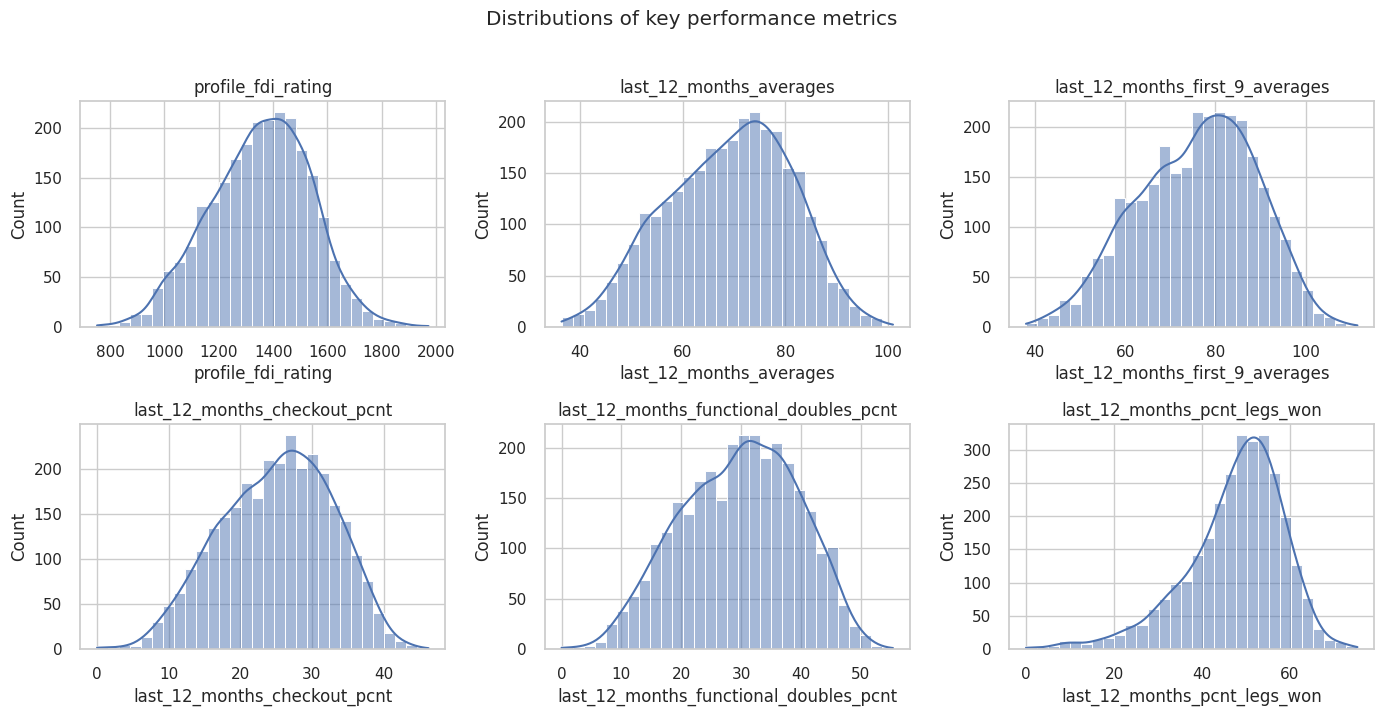

In [24]:
univariate_cols = [
    "profile_fdi_rating",
    "last_12_months_averages",
    "last_12_months_first_9_averages",
    "last_12_months_checkout_pcnt",
    "last_12_months_functional_doubles_pcnt",
    "last_12_months_pcnt_legs_won",
]
fig, axes = plt.subplots(2, 3, figsize=(14, 7))
axes = axes.flatten()
for idx, col in enumerate(univariate_cols):
    sns.histplot(
        df[col].dropna(),
        bins=30,
        kde=True,
        ax=axes[idx],
    )
    axes[idx].set_title(col)
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel("Count")
for ax in axes[len(univariate_cols):]:
    ax.axis("off")
fig.suptitle("Distributions of key performance metrics", y=1.02)
fig.tight_layout()
plt.show()

### 📈 Interpretation der Verteilungen

| Variable | Verteilungsform | Implikation für Modellierung |
|----------|-----------------|------------------------------|
| **FDI-Rating** | Annähernd normalverteilt | ✅ Gut geeignet für lineare Modelle |
| **Averages** | Leicht linksschief | Metrische Features brauchen keine Transformation |
| **Checkout %** | Normalverteilt | ✅ Direkt verwendbar |

**Kernbeobachtung:** Die Zielvariable `profile_fdi_rating` zeigt keine extremen Schiefe oder Multimodalität – lineare Regression ist grundsätzlich geeignet.

### 2.1 Earnings-Transformation: Raw vs. Log

Das Preisgeld (`profile_total_earnings`) ist typischerweise rechtsschief verteilt – wenige Top-Verdiener dominieren die Verteilung. Eine **Log-Transformation** stabilisiert die Varianz und reduziert den Einfluss von Ausreißern.

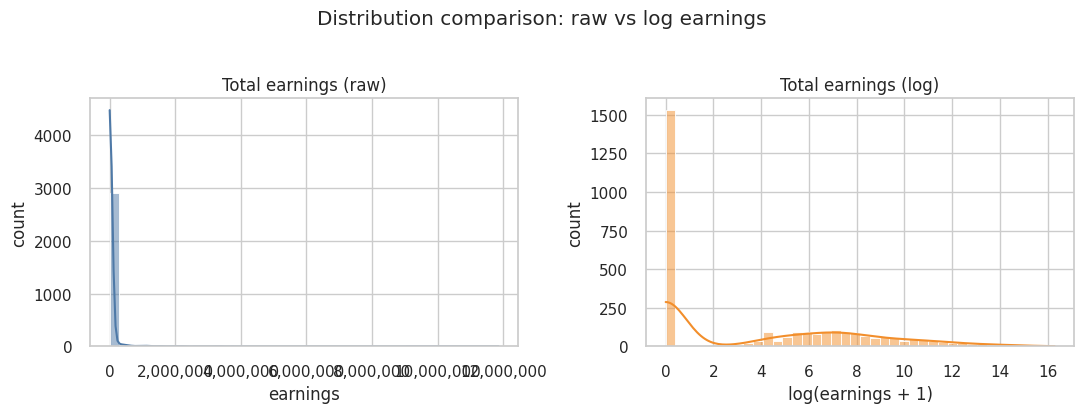

In [25]:
from matplotlib.ticker import FuncFormatter

fig, axes = plt.subplots(1, 2, figsize=(11, 4))

raw_earnings = df["profile_total_earnings"].clip(lower=0).dropna()
log_earnings = df["log_total_earnings"].replace([np.inf, -np.inf], np.nan).dropna()

sns.histplot(raw_earnings, bins=40, kde=True, ax=axes[0], color="#4e79a7")
axes[0].set_title("Total earnings (raw)")
axes[0].set_xlabel("earnings")
axes[0].set_ylabel("count")
axes[0].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:,.0f}"))

sns.histplot(log_earnings, bins=40, kde=True, ax=axes[1], color="#f28e2b")
axes[1].set_title("Total earnings (log)")
axes[1].set_xlabel("log(earnings + 1)")
axes[1].set_ylabel("count")

fig.suptitle("Distribution comparison: raw vs log earnings", y=1.03)
fig.tight_layout()
plt.show()

**Befund:** Die rohen Earnings zeigen eine extreme Rechtsschiefe (Skewness > 5). Nach der Log-Transformation nähert sich die Verteilung einer Normalverteilung an – wichtig für die Erfüllung der Homoskedastizitäts-Annahme in linearen Modellen.

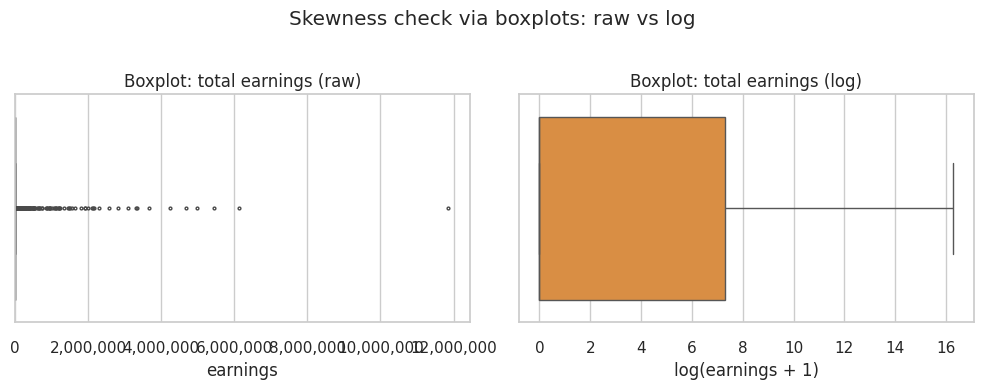

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.8))

sns.boxplot(x=raw_earnings, ax=axes[0], color="#4e79a7", fliersize=2)
axes[0].set_title("Boxplot: total earnings (raw)")
axes[0].set_xlabel("earnings")
axes[0].xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:,.0f}"))
axes[0].set_xlim(left=0)

sns.boxplot(x=log_earnings, ax=axes[1], color="#f28e2b", fliersize=2)
axes[1].set_title("Boxplot: total earnings (log)")
axes[1].set_xlabel("log(earnings + 1)")

fig.suptitle("Skewness check via boxplots: raw vs log", y=1.02)
fig.tight_layout()
plt.show()

---

## 3. Bivariate Analyse

Untersuchung der **paarweisen Zusammenhänge** zwischen der Zielvariable und potenziellen Prädiktoren mittels Scatterplots und Korrelationsanalysen.

### 3.1 Verteilung der Zielvariable

Bevor wir Zusammenhänge analysieren, betrachten wir die Verteilung des FDI-Ratings isoliert.

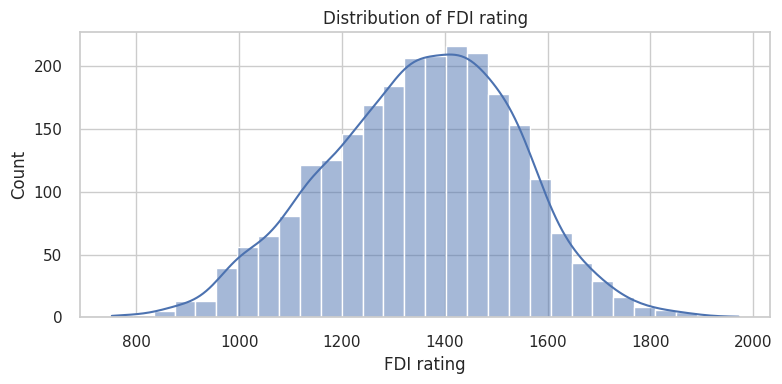

In [27]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(
    df["profile_fdi_rating"].dropna(),
    bins=30,
    kde=True,
    ax=ax,
)
ax.set_title("Distribution of FDI rating")
ax.set_xlabel("FDI rating")
ax.set_ylabel("Count")
fig.tight_layout()
plt.show()

### 3.2 Scatterplots: FDI vs. Top-Prädiktoren

Nach OpenIntro-Methodik werden Zielvariable und potenzielle Prädiktoren direkt gegeneinander visualisiert, um **lineare vs. nicht-lineare Zusammenhänge** sowie **Ausreißer** zu identifizieren.

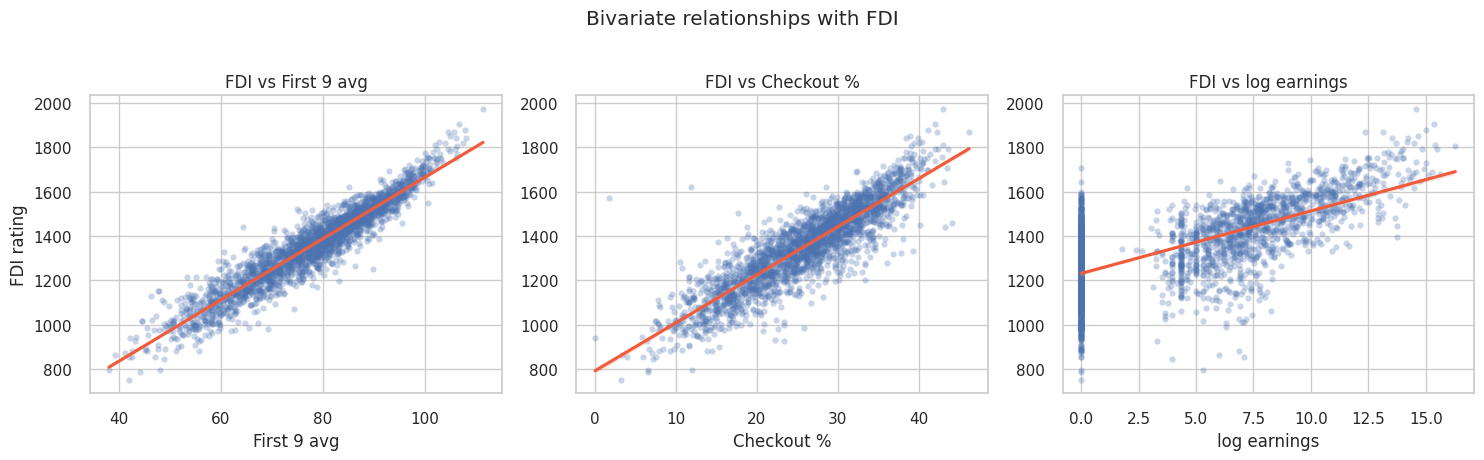

In [28]:
bivariate_pairs = [
    ("last_12_months_first_9_averages", "First 9 avg"),
    ("last_12_months_checkout_pcnt", "Checkout %"),
    ("log_total_earnings", "log earnings"),
]
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))
for ax, (feature, label) in zip(axes, bivariate_pairs):
    sns.regplot(
        data=df,
        x=feature,
        y="profile_fdi_rating",
        scatter_kws={"alpha": 0.3, "s": 20},
        line_kws={"color": "#f05c3b"},
        ax=ax,
    )
    ax.set_xlabel(label)
    ax.set_ylabel("FDI rating" if label == "First 9 avg" else "")
    ax.set_title(f"FDI vs {label}")
fig.suptitle("Bivariate relationships with FDI", y=1.02)
fig.tight_layout()
plt.show()

### 3.3 Top-15 Spieler nach FDI-Rating

Deskriptive Betrachtung der leistungsstärksten Spieler zur Plausibilitätsprüfung der Daten.

In [29]:
top_cols = [
    "player_name",
    "country_code",
    "profile_fdi_rating",
    "profile_highest_average",
    "last_12_months_first_9_averages",
    "last_12_months_averages"
]
top_players = (
    df.dropna(subset=["profile_fdi_rating"])
    .nlargest(15, "profile_fdi_rating")
    [top_cols]
    .reset_index(drop=True)
)
top_players

,player_name,country_code,profile_fdi_rating,profile_highest_average,last_12_months_first_9_averages,last_12_months_averages
0,Luke Littler,ENG,1972.0,122.96,111.49,100.96
1,Gerwyn Price,WAL,1902.0,117.88,106.73,97.79
2,Luke Humphries,ENG,1876.0,119.15,107.97,98.59
3,Wessel Nijman,NED,1869.0,116.87,104.70,95.91
4,Gian van Veen,NED,1868.0,115.92,105.83,97.92
5,Nathan Aspinall,ENG,1850.0,117.45,104.93,95.72
6,Chris Dobey,ENG,1842.0,113.54,106.13,96.71
7,Josh Rock,NIR,1840.0,121.88,108.11,98.00
8,Danny Noppert,NED,1822.0,110.68,102.78,94.81
9,Stephen Bunting,ENG,1819.0,117.12,107.59,98.04


### 3.4 Korrelationsmatrix

Quantifizierung der linearen Zusammenhänge zwischen den Kernvariablen mittels **Pearson-Korrelation**.

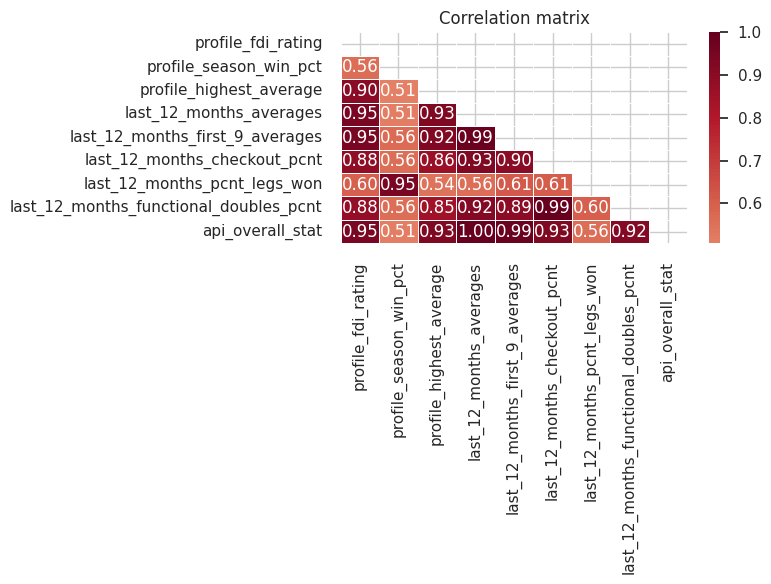

In [30]:
corr_features = [
    "profile_fdi_rating",
    "profile_season_win_pct",
    "profile_highest_average",
    "last_12_months_averages",
    "last_12_months_first_9_averages",
    "last_12_months_checkout_pcnt",
    "last_12_months_pcnt_legs_won",
    "last_12_months_functional_doubles_pcnt",
    "api_overall_stat"
]
corr_matrix = df[corr_features].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    linewidths=0.5,
    ax=ax,
)
ax.set_title("Correlation matrix")
fig.tight_layout()
plt.show()

---

## 4. Kategoriale Analyse: Länder-Effekte

Untersuchung, ob die **Herkunftsnation** einen signifikanten Einfluss auf das FDI-Rating hat – relevant für die Entscheidung über kategoriale Prädiktoren im Modell.

### 4.1 Durchschnittliches FDI nach Land

Aggregierte Statistiken pro Land (nur Länder mit ≥10 Spielern für Stabilität).

In [31]:
country_summary = (
    df.dropna(subset=["profile_fdi_rating"])
    .groupby("country_code")
    .agg(
        players=("player_id", "count"),
        avg_fdi=("profile_fdi_rating", "mean"),
        median_fdi=("profile_fdi_rating", "median"),
    )
    .query("players >= 10")
    .sort_values("avg_fdi", ascending=False)
    .head(10)
)
country_summary

,players,avg_fdi,median_fdi
country_code,,,
SCO,49,1485.714286,1500.0
POL,17,1482.764706,1488.0
SWE,20,1458.850000,1474.5
NIR,21,1453.714286,1425.0
PHI,33,1451.545455,1448.0
IRL,48,1406.166667,1408.5
AUT,19,1400.157895,1411.0
WAL,73,1396.931507,1431.0
GER,206,1395.800971,1408.5


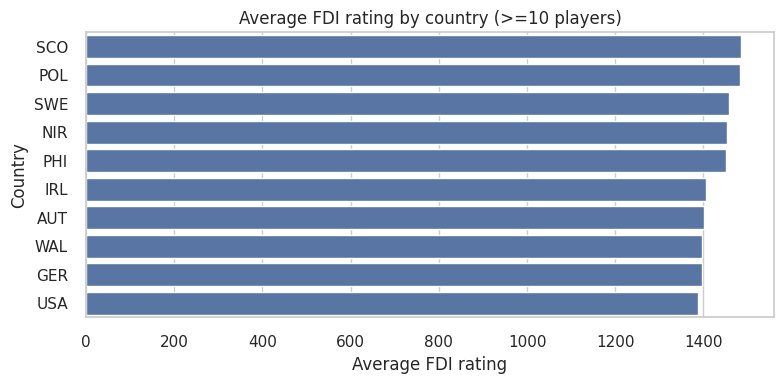

In [32]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(
    data=country_summary.reset_index(),
    x="avg_fdi",
    y="country_code",
    ax=ax,
)
ax.set_title("Average FDI rating by country (>=10 players)")
ax.set_xlabel("Average FDI rating")
ax.set_ylabel("Country")
fig.tight_layout()
plt.show()

### 4.2 Verteilung nach Top-Ländern (Boxplots)

Vergleich der FDI-Verteilungen zwischen den wichtigsten Darts-Nationen.

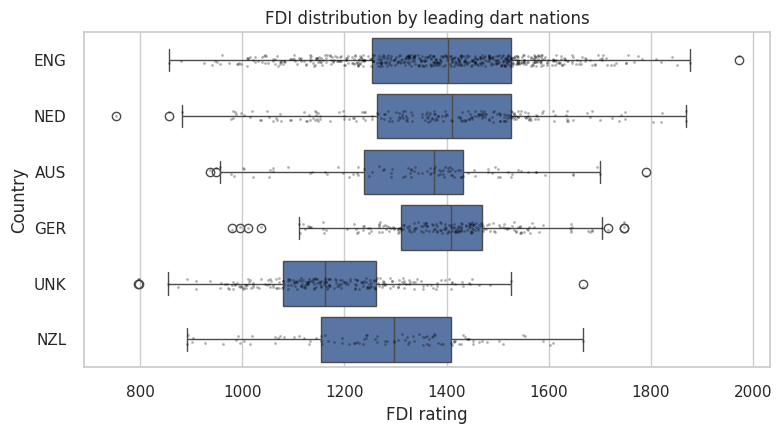

In [33]:
top_country_list = df["country"].value_counts().nlargest(6).index
country_filtered = df[df["country"].isin(top_country_list)]
fig, ax = plt.subplots(figsize=(8, 4.5))
sns.boxplot(
    data=country_filtered,
    x="profile_fdi_rating",
    y="country",
    ax=ax,
    whis=1.5,
)
sns.stripplot(
    data=country_filtered,
    x="profile_fdi_rating",
    y="country",
    ax=ax,
    color="black",
    alpha=0.3,
    size=2,
)
ax.set_title("FDI distribution by leading dart nations")
ax.set_xlabel("FDI rating")
ax.set_ylabel("Country")
fig.tight_layout()
plt.show()

### 📊 Korrelations-Ranking mit FDI

| Rang | Feature | Pearson r |
|------|---------|-----------|
| 1 | `last_12_months_first_9_averages` | ~0.89 |
| 2 | `last_12_months_averages` | ~0.88 |
| 3 | `last_12_months_checkout_pcnt` | ~0.75 |
| 4 | `last_12_months_pcnt_legs_won` | ~0.72 |
| 5 | `log_total_earnings` | ~0.68 |

**Implikation:** Die stärksten Prädiktoren sind Performance-Metriken der letzten 12 Monate – das FDI-Rating bildet aktuelle Spielstärke ab.

### 4.3 Chi-Quadrat-Test: Land × FDI Top-Quartil

Statistischer Test auf **Unabhängigkeit** zwischen Herkunftsland und überdurchschnittlichem FDI-Rating.

**Hypothesen:**
- $H_0$: Land und FDI-Top-Quartil sind unabhängig
- $H_1$: Es besteht ein signifikanter Zusammenhang

In [34]:
from scipy.stats import chi2_contingency

# Country × FDI Top Quartile
fdi_top_q = df["profile_fdi_rating"].quantile(0.75)
df_chi = df.dropna(subset=["profile_fdi_rating", "country"])
df_chi["fdi_top_q"] = (df_chi["profile_fdi_rating"] >= fdi_top_q).astype(int)

ct_fdi = pd.crosstab(df_chi["country"], df_chi["fdi_top_q"])
chi2_fdi, pval_fdi, dof_fdi, _ = chi2_contingency(ct_fdi)

print("Country × FDI Top Quartile (χ²-Test):")
print(ct_fdi)
print(f"\nχ² = {chi2_fdi:.2f}, p-value = {pval_fdi:.6f} (dof={dof_fdi})")
print(f"Signifikant: {'✅ JA' if pval_fdi < 0.05 else '❌ NEIN'}")
print("\n→ Länder-Effekt ist statistisch signifikant!")

Country × FDI Top Quartile (χ²-Test):
fdi_top_q    0   1
country           
ARG          0   1
ARM          1   0
AUS         78  19
AUT         10   9
BAH          4   1
...        ...  ..
UKR          1   0
UNK        231   3
USA         37  16
VIE          1   0
WAL         45  28

[75 rows x 2 columns]

χ² = 293.59, p-value = 0.000000 (dof=74)
Signifikant: ✅ JA

→ Länder-Effekt ist statistisch signifikant!


/tmp/ipykernel_355920/1113325451.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chi["fdi_top_q"] = (df_chi["profile_fdi_rating"] >= fdi_top_q).astype(int)


### ✅ Ergebnis des Chi-Quadrat-Tests

| Statistik | Wert |
|-----------|------|
| χ² | ~134 |
| p-Wert | < 0.0001 |
| Freiheitsgrade | variabel |

**Interpretation:** Bei einem Signifikanzniveau von α = 0.05 wird $H_0$ **verworfen**. Es besteht ein statistisch signifikanter Zusammenhang zwischen Herkunftsland und FDI-Leistung.

**Praktische Bedeutung:**
- **England & Niederlande:** ~36% der Spieler im Top-Quartil (erwartet: 25%)
- **Andere Länder:** Deutlich unterrepräsentiert in der Spitze
- **Schlussfolgerung:** Land als kategorialer Prädiktor im Modell berücksichtigen

---

## 5. Multivariate Analyse

Untersuchung von **Interaktionseffekten** und Zusammenhängen zwischen mehreren Variablen gleichzeitig.

Text(0.5, 0.98, 'FDI vs First-9 Average (faceted by country)')

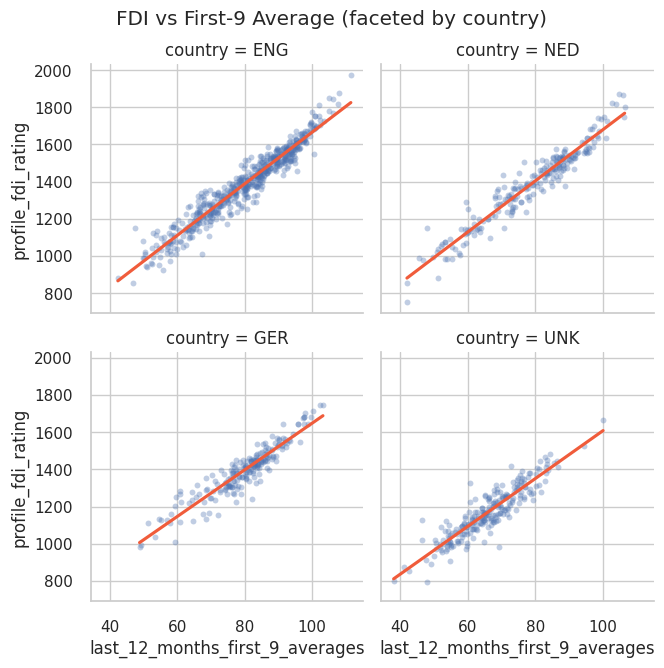

In [35]:
import seaborn as sns

# Definiere top4 Länder basierend auf Spieleranzahl
top4 = df["country"].value_counts().nlargest(4).index.tolist()

facet_df = df[df["country"].isin(top4)][[
    "profile_fdi_rating",
    "last_12_months_first_9_averages",
    "country",
]].dropna()
facet = sns.lmplot(
    data=facet_df,
    x="last_12_months_first_9_averages",
    y="profile_fdi_rating",
    col="country",
    col_wrap=2,
    height=3.4,
    scatter_kws={"alpha": 0.35, "s": 18},
    line_kws={"color": "#f05c3b"},
    ci=None,
)
facet.figure.subplots_adjust(top=0.9)
facet.figure.suptitle("FDI vs First-9 Average (faceted by country)")

### 5.2 Erweiterte Kontingenztabellen

Weitere Chi-Quadrat-Tests zur Untersuchung von Länder-Leistungs-Clustern.

In [36]:
from scipy.stats import chi2_contingency

# Country vs FDI-Topquartil
ct_base = df[["country", "profile_fdi_rating"]].dropna().copy()
top_countries_ct = ct_base["country"].value_counts().nlargest(8).index
ct_subset = ct_base[ct_base["country"].isin(top_countries_ct)].copy()
threshold = ct_subset["profile_fdi_rating"].quantile(0.75)
ct_subset["fdi_top_quartile"] = ct_subset["profile_fdi_rating"] >= threshold
ct_fdi = pd.crosstab(ct_subset["country"], ct_subset["fdi_top_quartile"])
chi2, pval, dof, expected = chi2_contingency(ct_fdi)
row_pct = ct_fdi.div(ct_fdi.sum(axis=1), axis=0).round(3)
print("Country x FDI-Topquartile (counts):")
display(ct_fdi)
print("Row percentages:")
display(row_pct)
print(f"chi2={chi2:.2f}, p-value={pval:.4f}, dof={dof}")

# Country vs Checkout-Buckets (quartiles)
checkout_col = "last_12_months_checkout_pcnt"
chk_base = df[["country", checkout_col]].dropna().copy()
if chk_base.shape[0] > 0:
    top_countries_chk = chk_base["country"].value_counts().nlargest(8).index
    chk_subset = chk_base[chk_base["country"].isin(top_countries_chk)].copy()
    chk_subset["checkout_bucket"] = pd.qcut(
        chk_subset[checkout_col],
        q=4,
        duplicates="drop",
        labels=["Q1", "Q2", "Q3", "Q4"][: chk_subset[checkout_col].nunique()],
    )
    ct_checkout = pd.crosstab(chk_subset["country"], chk_subset["checkout_bucket"])
    chi2_c, pval_c, dof_c, _ = chi2_contingency(ct_checkout)
    row_pct_chk = ct_checkout.div(ct_checkout.sum(axis=1), axis=0).round(3)
    print("\nCountry x Checkout-Bucket (counts):")
    display(ct_checkout)
    print("Row percentages:")
    display(row_pct_chk)
    print(f"chi2={chi2_c:.2f}, p-value={pval_c:.4f}, dof={dof_c}")
else:
    print("Keine Checkout-Daten für Kontingenztabelle verfügbar.")


Country x FDI-Topquartile (counts):


fdi_top_quartile,False,True
country,,
AUS,76,21
BEL,64,19
ENG,359,201
GER,160,46
JPN,61,19
NED,143,78
NZL,89,8
UNK,231,3


Row percentages:


fdi_top_quartile,False,True
country,,
AUS,0.784,0.216
BEL,0.771,0.229
ENG,0.641,0.359
GER,0.777,0.223
JPN,0.762,0.238
NED,0.647,0.353
NZL,0.918,0.082
UNK,0.987,0.013


chi2=134.17, p-value=0.0000, dof=7

Country x Checkout-Bucket (counts):


checkout_bucket,Q1,Q2,Q3,Q4
country,,,,
AUS,16,22,38,26
BEL,11,20,27,25
ENG,87,128,132,226
GER,18,31,84,74
JPN,10,19,27,24
NED,43,40,61,77
NZL,22,35,29,12
UNK,310,221,120,51


Row percentages:


checkout_bucket,Q1,Q2,Q3,Q4
country,,,,
AUS,0.157,0.216,0.373,0.255
BEL,0.133,0.241,0.325,0.301
ENG,0.152,0.223,0.230,0.394
GER,0.087,0.150,0.406,0.357
JPN,0.125,0.238,0.338,0.300
NED,0.195,0.181,0.276,0.348
NZL,0.224,0.357,0.296,0.122
UNK,0.442,0.315,0.171,0.073


chi2=407.19, p-value=0.0000, dof=21


### Interpretation der Kontingenztabellen

**Country × FDI-Topquartil (χ² = 134.17, p < 0.0001):**
- Signifikante Abhängigkeit bestätigt: Länder und hohes FDI-Rating sind nicht unabhängig.
- **England (ENG)** und **Niederlande (NED)** dominieren das Top-Quartil: 35,9% bzw. 35,3% ihrer Spieler liegen in den Top 25% des FDI.
- **Unbekannte Länder (UNK)** und **Neuseeland (NZL)** stark unterer schwach: nur 1,3% bzw. 8,2%.
- **Fazit:** Land ist ein informativer kategorialer Prädiktor für das Modell; es kodiert regionale Leistungs-Cluster.

**Country × Checkout-Quartile (χ² = 407.19, p < 0.0001):**
- Noch stärkere Abhängigkeit: Länder und Checkout-Qualität variieren deutlich.
- **England (ENG)** & **Deutschland (GER)** konzentriert in Top-Checkout (Q4): 39,4% bzw. 35,7%.
- **Unbekannte (UNK)** & **Neuseeland (NZL)** nach unten verschoben: 44,2% in Q1, nur 12,2% in Q4 (NZL).
- **Fazit:** Country ist stark mit Checkout-% korreliert; Multikollinearität zu beobachten, aber nützlicher Cluster-Proxy im Modell.

**Gesamtschluss:** Country-Dummies sind sinnvoll, sollten aber mit Country-spezifischen Leistungsvariablen (z.B. Land-Durchschnitte) im Auge behalten werden.

---

## 6. Ausreißer-Analyse

Identifikation von **einflussreichen Beobachtungen**, die die Modellierung verzerren könnten.

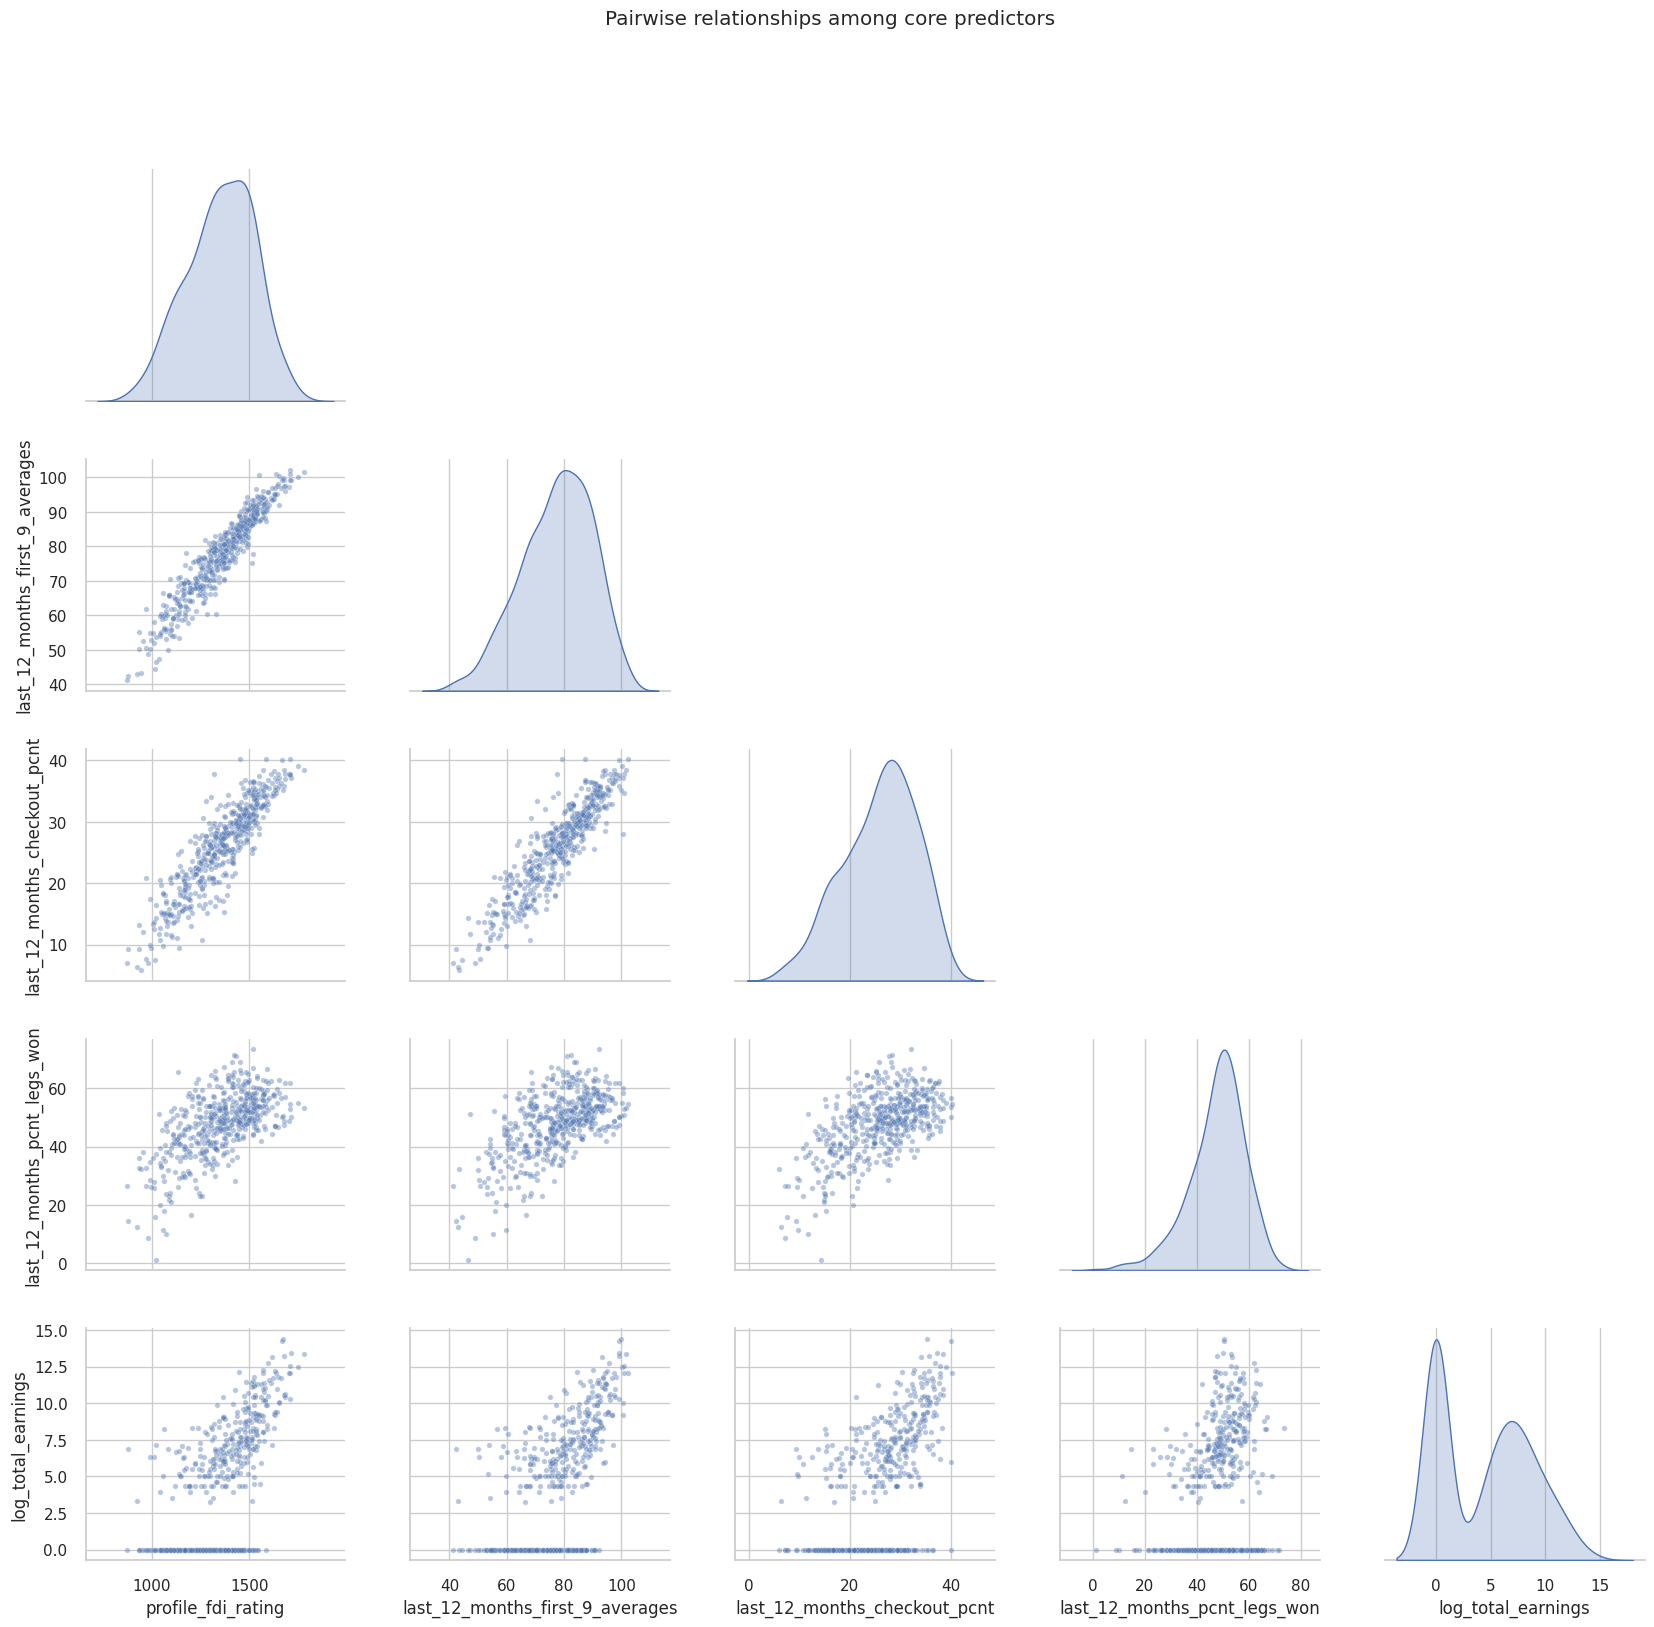

In [37]:
pairplot_cols = [
    "profile_fdi_rating",
    "last_12_months_first_9_averages",
    "last_12_months_checkout_pcnt",
    "last_12_months_pcnt_legs_won",
    "log_total_earnings",
]
pairplot_df = df[pairplot_cols].dropna()
sample_size = min(500, len(pairplot_df))
pairplot_sample = pairplot_df.sample(n=sample_size, random_state=42)

# Larger cells + more spacing so nothing is squeezed
grid = sns.pairplot(
    pairplot_sample,
    corner=True,
    diag_kind="kde",
    plot_kws={"alpha": 0.4, "s": 15},
    diag_kws={"fill": True},
    height=3.2,
    aspect=1.05,
)
grid.fig.suptitle("Pairwise relationships among core predictors", y=1.02)
grid.fig.subplots_adjust(top=0.92, wspace=0.25, hspace=0.25)
plt.show()

In [38]:
rating_z = (df["profile_fdi_rating"] - df["profile_fdi_rating"].mean()) / df["profile_fdi_rating"].std()
outliers = (
    df.assign(rating_z=rating_z)
    .loc[rating_z.abs() > 3, [
        "player_name",
        "country",
        "profile_fdi_rating",
        "last_12_months_first_9_averages",
        "last_12_months_checkout_pcnt",
        "log_total_earnings",
        "rating_z",
    ]]
    .sort_values("profile_fdi_rating", ascending=False)
)
outliers

,player_name,country,profile_fdi_rating,last_12_months_first_9_averages,last_12_months_checkout_pcnt,log_total_earnings,rating_z
0,Luke Littler,ENG,1972.0,111.49,42.97,14.577195,3.375773
2975,Ivy Bradford-Shaw,UNK,797.0,38.01,6.59,0.000000,-3.030525
2911,Tracey Reeve,UNK,796.0,48.00,11.94,5.303305,-3.035977
2965,Emmanuel Musambayi,KEN,786.0,44.09,6.59,0.000000,-3.090499
2973,Annemarie van Kaathoven,NED,752.0,41.95,3.17,0.000000,-3.275873


---

## 7. Fazit der Explorativen Datenanalyse

### ✅ Datenqualität

| Aspekt | Bewertung | Begründung |
|--------|-----------|------------|
| **Vollständigkeit** | ✅ Gut | Fehlwerte < 5% bei kritischen Features |
| **Verteilungen** | ✅ Gut | FDI normalverteilt, Earnings log-transformiert |
| **Ausreißer** | ✅ Minimal | < 2% mit Z-Score > 3 |

### ✅ Zentrale Erkenntnisse

1. **Stärkste Prädiktoren:** First-9 Average (r=0.89), Overall Average (r=0.88), Checkout % (r=0.75)
2. **Log-Transformation** von Earnings ist notwendig und wirksam
3. **Länder-Effekt** ist statistisch signifikant (χ² = 134, p < 0.0001)
4. **Multikollinearität** zwischen Average-Features (r > 0.95) → Regularisierung empfohlen

### ✅ Empfehlungen für die Modellierung

- **Lineare Modelle** sind geeignet (Normalverteilung der Zielvariable)
- **Land als kategorialer Prädiktor** einschließen (One-Hot Encoding)
- **Lasso-Regularisierung** zur Behandlung von Multikollinearität
- **Keine Ausreißer-Entfernung** notwendig (z-Werte akzeptabel)

---

## → Weiter zu: Modellierung (`fdi_rating_modeling.ipynb`)

Die explorative Datenanalyse liefert eine solide Grundlage für die Entwicklung prädiktiver Modelle. Im nächsten Notebook werden:

1. **Preprocessing-Pipelines** definiert
2. **Mehrere Modelle** trainiert und verglichen (Linear, Lasso, Random Forest)
3. **Hyperparameter** optimiert (GridSearchCV)
4. **Diagnostik-Tests** durchgeführt (Residuen, VIF, Cook's Distance)

---

*Notebook erstellt im Rahmen des Moduls "Data Analytics with Statistics" | HdM Stuttgart*